In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold,validation_curve
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx
/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv


In [2]:
pcos_infertility = pd.read_csv('/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv')
pcos_wo_infertility = pd.read_excel('/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx',sheet_name="Full_new")

In [3]:
pcos_infertility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3     I   beta-HCG(mIU/mL)  541 non-null    float64
 4   II    beta-HCG(mIU/mL)  541 non-null    float64
 5   AMH(ng/mL)              541 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 25.5+ KB


In [4]:
pcos_wo_infertility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    float64
 1   Patient File No.        541 non-null    float64
 2   PCOS (Y/N)              541 non-null    float64
 3    Age (yrs)              541 non-null    float64
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    float64
 8   Pulse rate(bpm)         541 non-null    float64
 9   RR (breaths/min)        541 non-null    float64
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    float64
 12  Cycle length(days)      541 non-null    float64
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    fl

Data Preprocessing:


In [5]:
#Merging the two files as per patient file no. 
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(pcos_wo_infertility, pcos_infertility, on='Patient File No.', suffixes={'','_y'},how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head() 

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1.0,1.0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,...,0.0,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5
1,2.0,2.0,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,...,0.0,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7
2,3.0,3.0,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,...,1.0,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0
3,4.0,4.0,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,...,0.0,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5
4,5.0,5.0,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,...,0.0,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    float64
 1   Patient File No.        541 non-null    float64
 2   PCOS (Y/N)              541 non-null    float64
 3    Age (yrs)              541 non-null    float64
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    float64
 8   Pulse rate(bpm)         541 non-null    float64
 9   RR (breaths/min)        541 non-null    float64
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    float64
 12  Cycle length(days)      541 non-null    float64
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    fl

In [7]:
#renaming the columns
data.rename(columns = {' Age (yrs)': 'Age (years)','Marraige Status (Yrs)': 'Marriage Status (Yrs)','  I   beta-HCG(mIU/mL)':'I beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)':'II beta-HCG(mIU/mL)', 'BP _Systolic (mmHg)': 'BP Systolic (mmHg)','BP _Diastolic (mmHg)':'BP Diastolic (mmHg)'}, inplace = True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sl. No                 541 non-null    float64
 1   Patient File No.       541 non-null    float64
 2   PCOS (Y/N)             541 non-null    float64
 3   Age (years)            541 non-null    float64
 4   Weight (Kg)            541 non-null    float64
 5   Height(Cm)             541 non-null    float64
 6   BMI                    541 non-null    float64
 7   Blood Group            541 non-null    float64
 8   Pulse rate(bpm)        541 non-null    float64
 9   RR (breaths/min)       541 non-null    float64
 10  Hb(g/dl)               541 non-null    float64
 11  Cycle(R/I)             541 non-null    float64
 12  Cycle length(days)     541 non-null    float64
 13  Marriage Status (Yrs)  540 non-null    float64
 14  Pregnant(Y/N)          541 non-null    float64
 15  No. of

Encoding categorical variables

In [9]:
#Having a look at the data with dtype objects

data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [10]:
#Similarly

data["II beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II beta-HCG(mIU/mL), dtype: object

After having a look at this info we conclude that:
Some numeric data are saved as strings.
There are some missing values. Ex : Marriage Status (Yrs)& Fast food (Y/N)

In [11]:
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II beta-HCG(mIU/mL)"] = pd.to_numeric(data["II beta-HCG(mIU/mL)"], errors='coerce')

In [12]:
#checking the null values
data.isnull().sum()

Sl. No                   0
Patient File No.         0
PCOS (Y/N)               0
Age (years)              0
Weight (Kg)              0
Height(Cm)               0
BMI                      0
Blood Group              0
Pulse rate(bpm)          0
RR (breaths/min)         0
Hb(g/dl)                 0
Cycle(R/I)               0
Cycle length(days)       0
Marriage Status (Yrs)    1
Pregnant(Y/N)            0
No. of aborptions        0
I beta-HCG(mIU/mL)       0
II beta-HCG(mIU/mL)      1
FSH(mIU/mL)              0
LH(mIU/mL)               0
FSH/LH                   0
Hip(inch)                0
Waist(inch)              0
Waist:Hip Ratio          0
TSH (mIU/L)              0
AMH(ng/mL)               1
PRL(ng/mL)               0
Vit D3 (ng/mL)           0
PRG(ng/mL)               0
RBS(mg/dl)               0
Weight gain(Y/N)         0
hair growth(Y/N)         0
Skin darkening (Y/N)     0
Hair loss(Y/N)           0
Pimples(Y/N)             0
Fast food (Y/N)          1
Reg.Exercise(Y/N)        0
B

In [13]:
#check duplicate values
duplicate = data[data.duplicated()]
duplicate

,Sl. No,Patient File No.,PCOS (Y/N),Age (years),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP Systolic (mmHg),BP Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)


In [14]:
for col in data.columns:
    print(col)

Sl. No
Patient File No.
PCOS (Y/N)
Age (years)
Weight (Kg)
Height(Cm) 
BMI
Blood Group
Pulse rate(bpm) 
RR (breaths/min)
Hb(g/dl)
Cycle(R/I)
Cycle length(days)
Marriage Status (Yrs)
Pregnant(Y/N)
No. of aborptions
I beta-HCG(mIU/mL)
II beta-HCG(mIU/mL)
FSH(mIU/mL)
LH(mIU/mL)
FSH/LH
Hip(inch)
Waist(inch)
Waist:Hip Ratio
TSH (mIU/L)
AMH(ng/mL)
PRL(ng/mL)
Vit D3 (ng/mL)
PRG(ng/mL)
RBS(mg/dl)
Weight gain(Y/N)
hair growth(Y/N)
Skin darkening (Y/N)
Hair loss(Y/N)
Pimples(Y/N)
Fast food (Y/N)
Reg.Exercise(Y/N)
BP Systolic (mmHg)
BP Diastolic (mmHg)
Follicle No. (L)
Follicle No. (R)
Avg. F size (L) (mm)
Avg. F size (R) (mm)
Endometrium (mm)


REMOVING NULL VALUES

In [15]:
data.isnull().sum()

Sl. No                   0
Patient File No.         0
PCOS (Y/N)               0
Age (years)              0
Weight (Kg)              0
Height(Cm)               0
BMI                      0
Blood Group              0
Pulse rate(bpm)          0
RR (breaths/min)         0
Hb(g/dl)                 0
Cycle(R/I)               0
Cycle length(days)       0
Marriage Status (Yrs)    1
Pregnant(Y/N)            0
No. of aborptions        0
I beta-HCG(mIU/mL)       0
II beta-HCG(mIU/mL)      1
FSH(mIU/mL)              0
LH(mIU/mL)               0
FSH/LH                   0
Hip(inch)                0
Waist(inch)              0
Waist:Hip Ratio          0
TSH (mIU/L)              0
AMH(ng/mL)               1
PRL(ng/mL)               0
Vit D3 (ng/mL)           0
PRG(ng/mL)               0
RBS(mg/dl)               0
Weight gain(Y/N)         0
hair growth(Y/N)         0
Skin darkening (Y/N)     0
Hair loss(Y/N)           0
Pimples(Y/N)             0
Fast food (Y/N)          1
Reg.Exercise(Y/N)        0
B

In [16]:
# data['Marriage Status (Yrs)'].median()
# data[data['Marriage Status (Yrs)'].isnull()==True]['Marriage Status (Yrs)'] = data['Marriage Status (Yrs)'].median()
data['Marriage Status (Yrs)'] = data['Marriage Status (Yrs)'].fillna(data['Marriage Status (Yrs)'].median())

In [17]:
# data['II beta-HCG(mIU/mL)'].median()
# data[data['II beta-HCG(mIU/mL)'].isnull()==True]['II beta-HCG(mIU/mL)']=data['II beta-HCG(mIU/mL)'].median()
data['II beta-HCG(mIU/mL)'] = data['II beta-HCG(mIU/mL)'].fillna(data['II beta-HCG(mIU/mL)'].median())

In [18]:
# data['AMH(ng/mL)'].median()
# data[data['AMH(ng/mL)'].isnull()==True]['AMH(ng/mL)']=data['AMH(ng/mL)'].median()
data['AMH(ng/mL)'] = data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median())

In [19]:
# data['Fast food (Y/N)'].median()
# data[data['Fast food (Y/N)'].isnull()==True]['Fast food (Y/N)']=data['Fast food (Y/N)'].median()
data['Fast food (Y/N)'] = data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median())

In [20]:
data.isnull().sum()

Sl. No                   0
Patient File No.         0
PCOS (Y/N)               0
Age (years)              0
Weight (Kg)              0
Height(Cm)               0
BMI                      0
Blood Group              0
Pulse rate(bpm)          0
RR (breaths/min)         0
Hb(g/dl)                 0
Cycle(R/I)               0
Cycle length(days)       0
Marriage Status (Yrs)    0
Pregnant(Y/N)            0
No. of aborptions        0
I beta-HCG(mIU/mL)       0
II beta-HCG(mIU/mL)      0
FSH(mIU/mL)              0
LH(mIU/mL)               0
FSH/LH                   0
Hip(inch)                0
Waist(inch)              0
Waist:Hip Ratio          0
TSH (mIU/L)              0
AMH(ng/mL)               0
PRL(ng/mL)               0
Vit D3 (ng/mL)           0
PRG(ng/mL)               0
RBS(mg/dl)               0
Weight gain(Y/N)         0
hair growth(Y/N)         0
Skin darkening (Y/N)     0
Hair loss(Y/N)           0
Pimples(Y/N)             0
Fast food (Y/N)          0
Reg.Exercise(Y/N)        0
B

Exploratory Data Analysis

Text(0.5, 0, '0 - Not PCOS, 1 - PCOS')

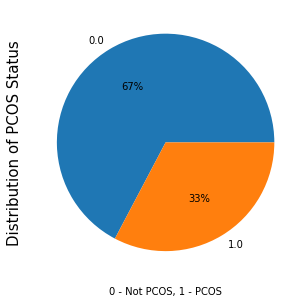

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 5))
data.groupby('PCOS (Y/N)').size().plot(kind='pie', autopct='%1.0f%%',)
ax1.set_ylabel('Distribution of PCOS Status', size=15)
ax1.set_xlabel('0 - Not PCOS, 1 - PCOS')

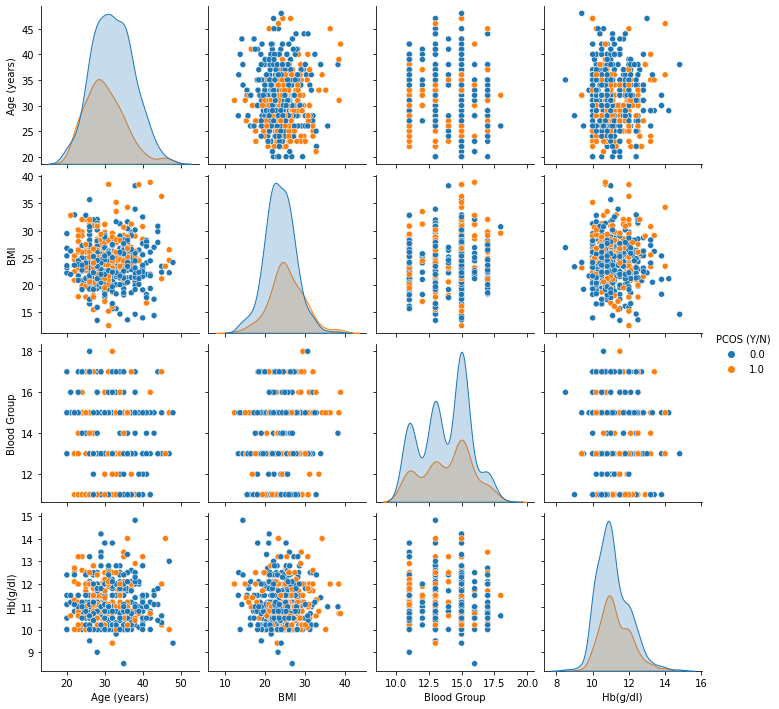

<Figure size 782.625x720 with 0 Axes>

In [22]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = ['Age (years)',
'BMI',
'Blood Group',
'Hb(g/dl)'],
y_vars = ['Age (years)',
'BMI',
'Blood Group',
'Hb(g/dl)'], diag_kind='kde')

sns_plot.savefig("pairplot.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot.png') # Show pairplot as image

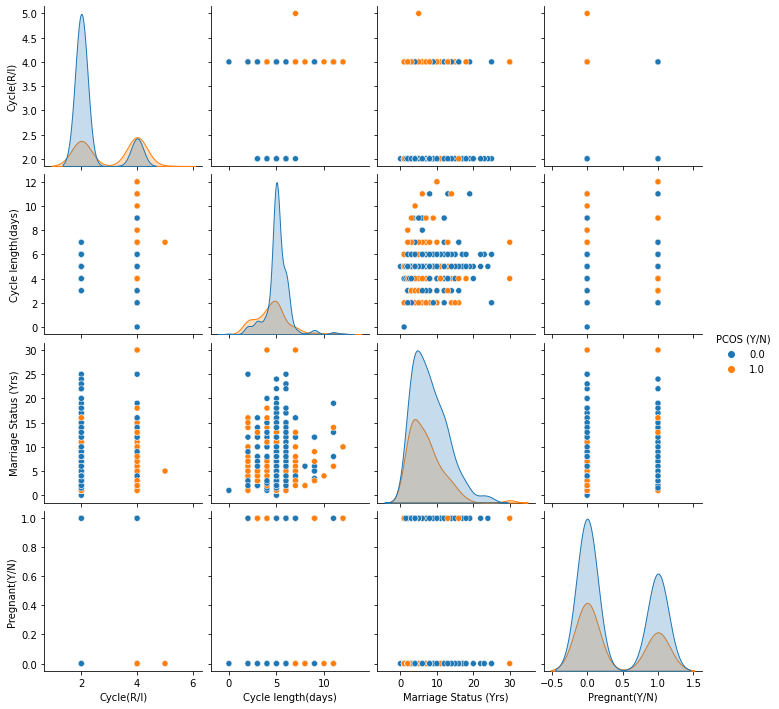

<Figure size 782.625x720 with 0 Axes>

In [23]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = [
'Cycle(R/I)',
'Cycle length(days)',
'Marriage Status (Yrs)',
'Pregnant(Y/N)'],
y_vars = [
'Cycle(R/I)',
'Cycle length(days)',
'Marriage Status (Yrs)',
'Pregnant(Y/N)'], diag_kind='kde')

sns_plot.savefig("pairplott.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplott.png') # Show pairplot as image

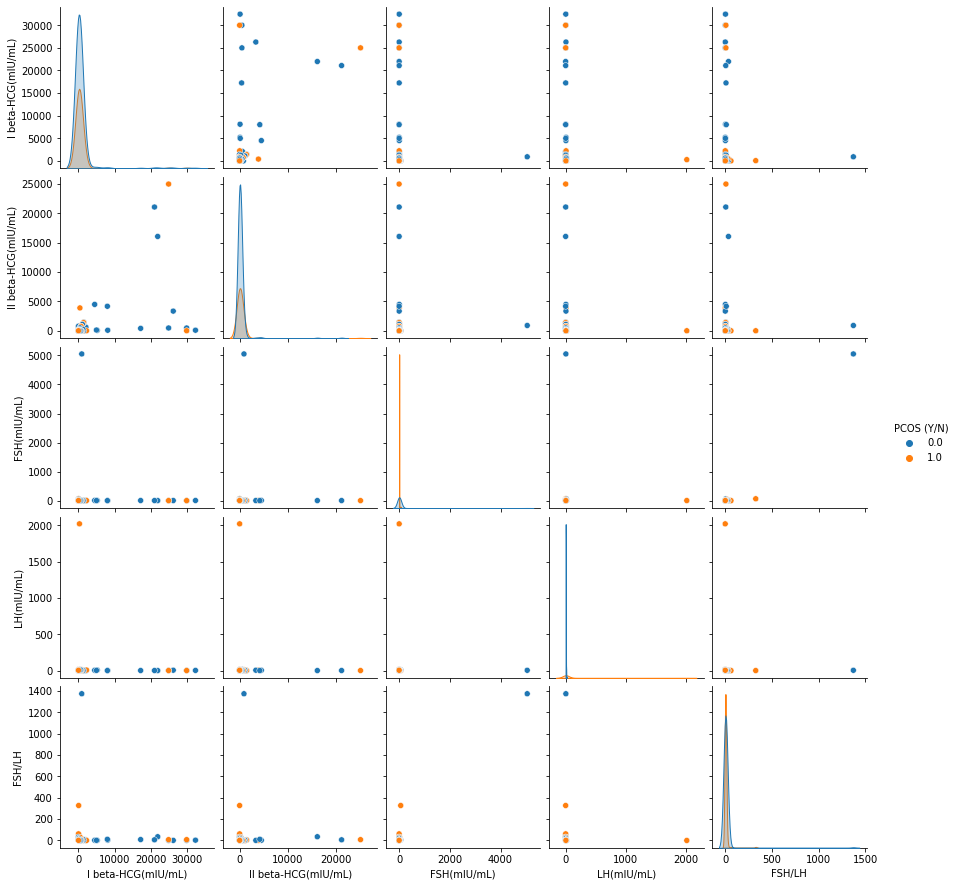

<Figure size 962.625x900 with 0 Axes>

In [24]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = ['I beta-HCG(mIU/mL)',
'II beta-HCG(mIU/mL)',
'FSH(mIU/mL)',
'LH(mIU/mL)',
'FSH/LH'],
y_vars = ['I beta-HCG(mIU/mL)',
'II beta-HCG(mIU/mL)',
'FSH(mIU/mL)',
'LH(mIU/mL)',
'FSH/LH'], diag_kind='kde')

sns_plot.savefig("pairplot1.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot1.png') # Show pairplot as image

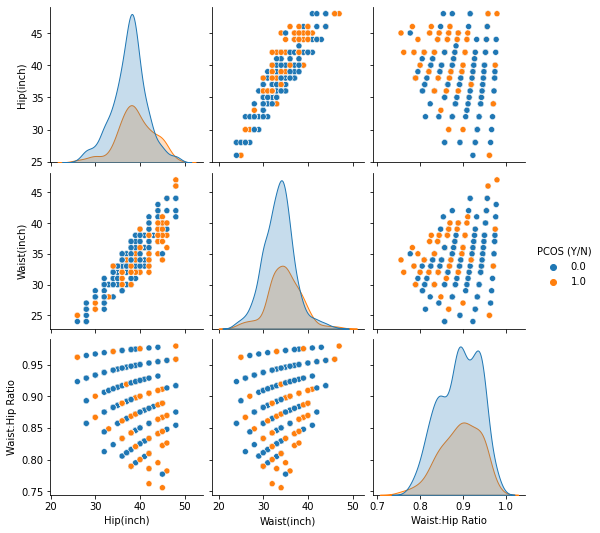

<Figure size 602.625x540 with 0 Axes>

In [25]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = ['Hip(inch)',
'Waist(inch)',
'Waist:Hip Ratio'],
y_vars = ['Hip(inch)',
'Waist(inch)',
'Waist:Hip Ratio'], diag_kind='kde')

sns_plot.savefig("pairplot2.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot2.png') # Show pairplot as image

In [26]:
print('Mean of Hip attribute: '+str(data['Hip(inch)'].describe()['mean']))
print('Variance of Hip attribute: '+str(data['Hip(inch)'].var(ddof=0)))

Mean of Hip attribute: 37.99260628465804
Variance of Hip attribute: 15.715287292308007


In [27]:
print('Mean of Waist attribute: '+str(data['Waist(inch)'].describe()['mean']))
print('Variance of Waist attribute: '+str(data['Waist(inch)'].var(ddof=0)))

Mean of Waist attribute: 33.84103512014787
Variance of Waist attribute: 12.913732015402436


In [28]:
print('Mean of Waist attribute: '+str(data['Waist:Hip Ratio'].describe()['mean']))
print('Variance of Waist attribute: '+str(data['Waist:Hip Ratio'].var(ddof=0)))

Mean of Waist attribute: 0.8918945873369686
Variance of Waist attribute: 0.002142101212983213


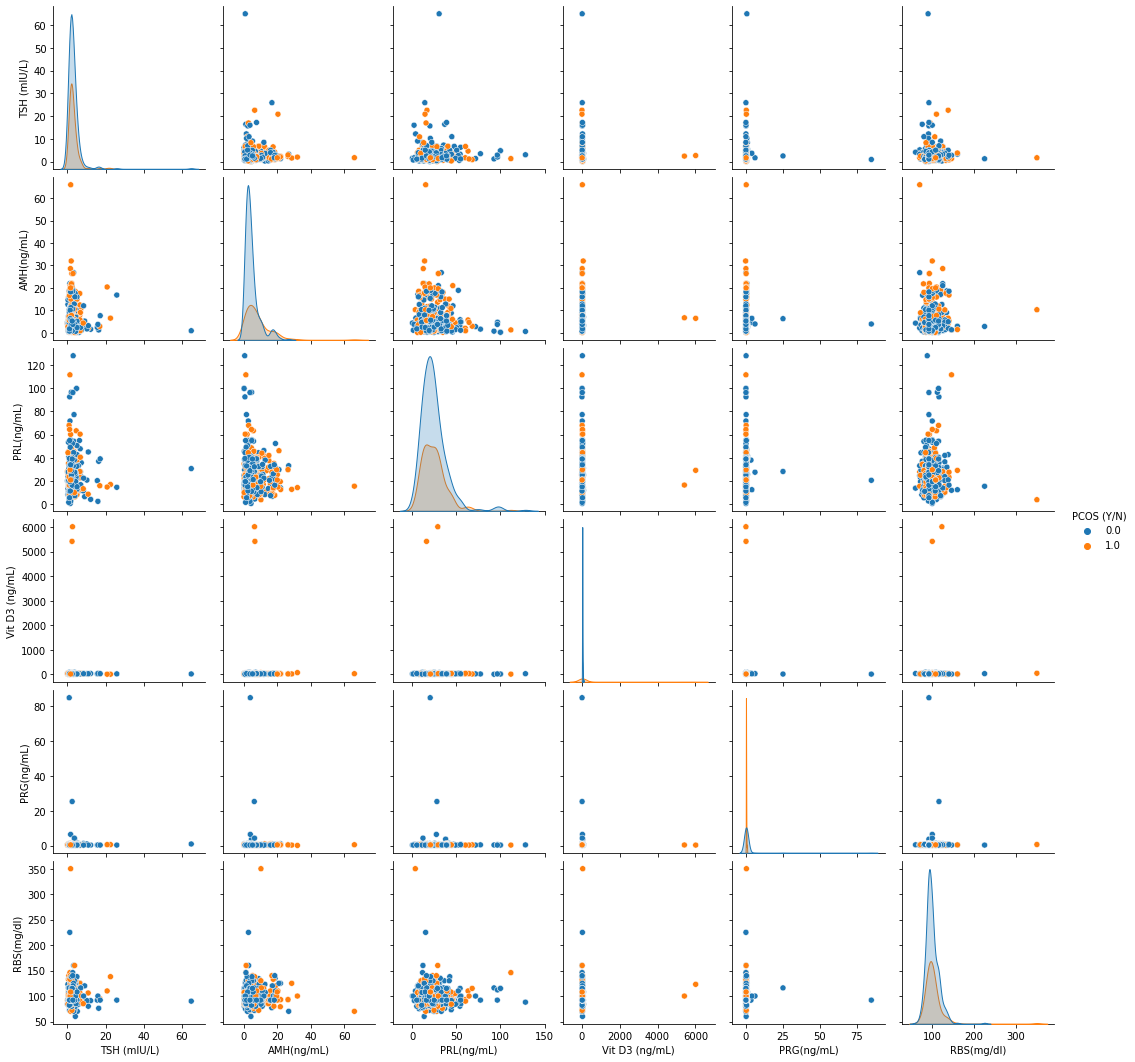

<Figure size 1142.62x1080 with 0 Axes>

In [29]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = ['TSH (mIU/L)',
'AMH(ng/mL)',
'PRL(ng/mL)',
'Vit D3 (ng/mL)',
'PRG(ng/mL)',
'RBS(mg/dl)'],
y_vars = ['TSH (mIU/L)',
'AMH(ng/mL)',
'PRL(ng/mL)',
'Vit D3 (ng/mL)',
'PRG(ng/mL)',
'RBS(mg/dl)'], diag_kind='kde')

sns_plot.savefig("pairplot3.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot3.png') # Show pairplot as image

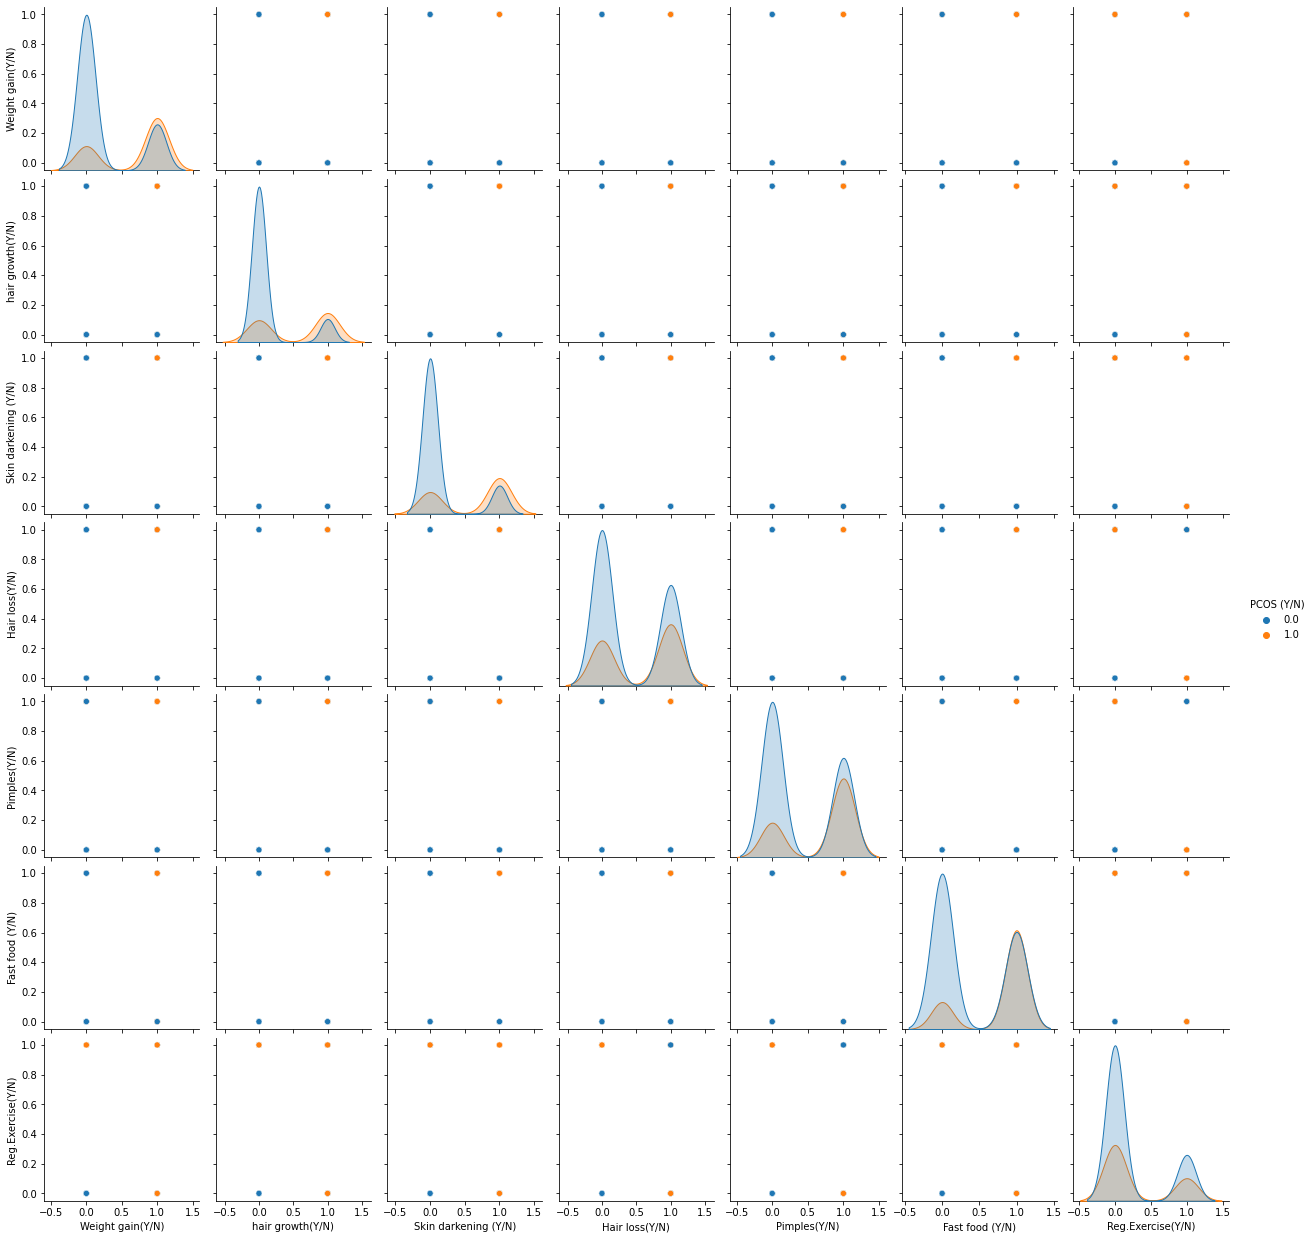

<Figure size 1322.62x1260 with 0 Axes>

In [30]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = ['Weight gain(Y/N)',
'hair growth(Y/N)',
'Skin darkening (Y/N)',
'Hair loss(Y/N)',
'Pimples(Y/N)',
'Fast food (Y/N)',
'Reg.Exercise(Y/N)'],
y_vars = ['Weight gain(Y/N)',
'hair growth(Y/N)',
'Skin darkening (Y/N)',
'Hair loss(Y/N)',
'Pimples(Y/N)',
'Fast food (Y/N)',
'Reg.Exercise(Y/N)'], diag_kind='kde')

sns_plot.savefig("pairplot4.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot4.png') # Show pairplot as image

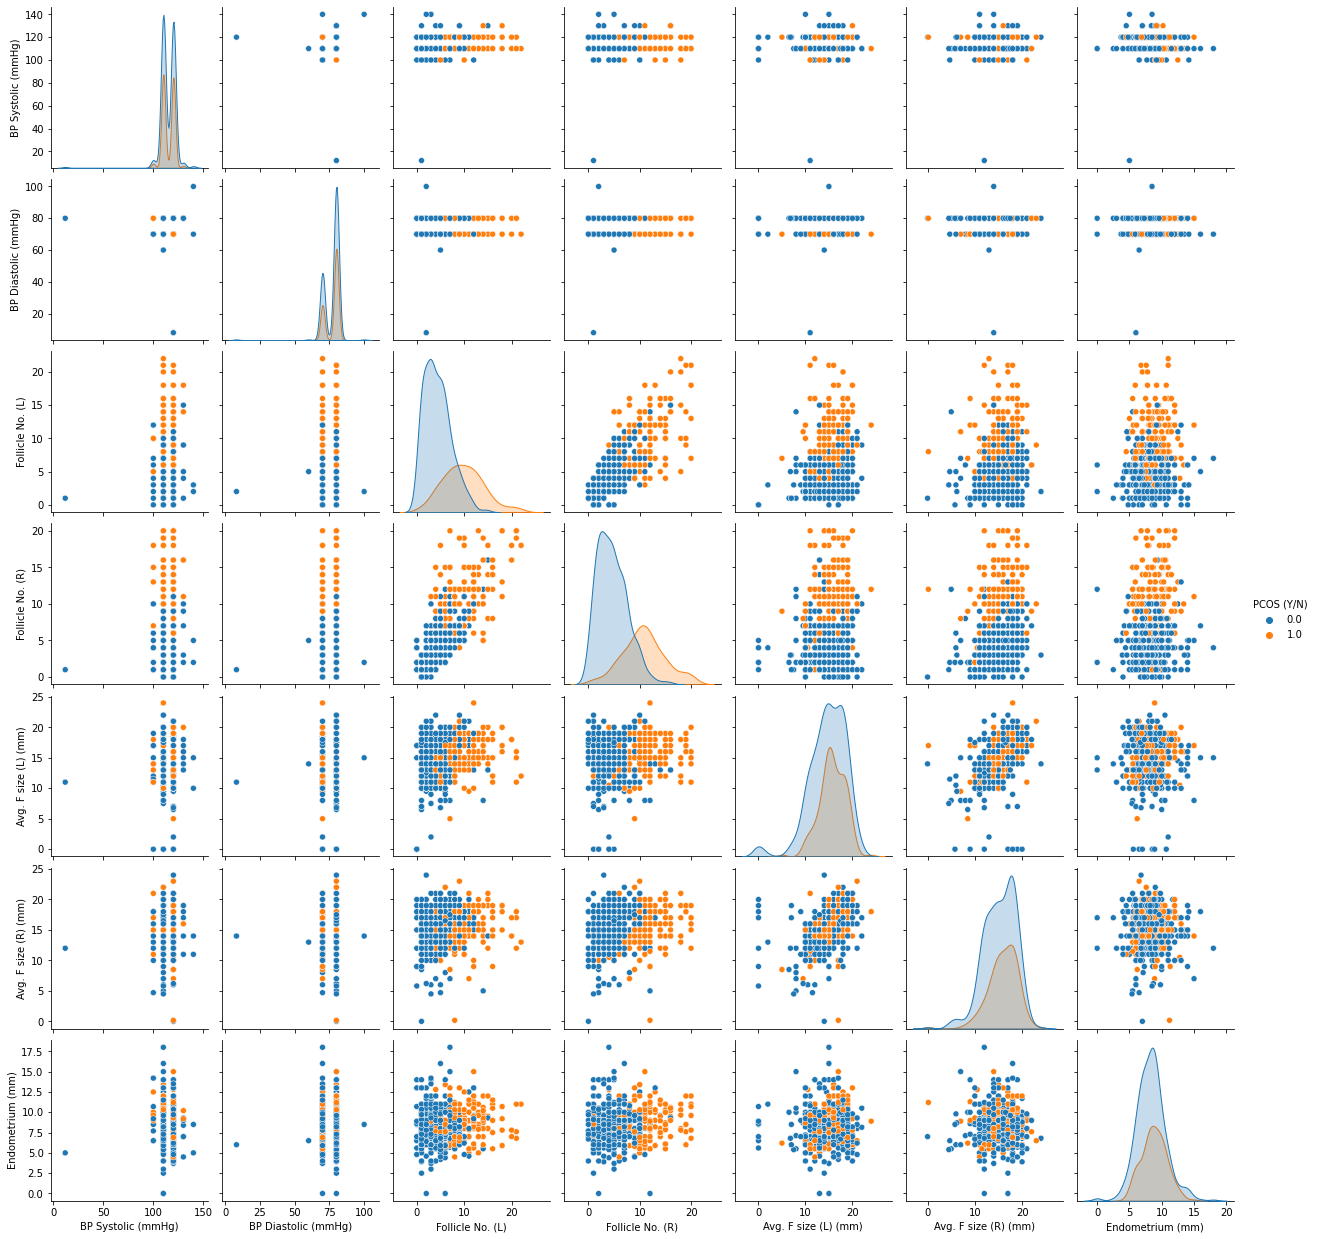

<Figure size 1322.62x1260 with 0 Axes>

In [31]:
sns_plot = sns.pairplot(data, hue='PCOS (Y/N)',x_vars = ['BP Systolic (mmHg)',
'BP Diastolic (mmHg)',
'Follicle No. (L)',
'Follicle No. (R)',
'Avg. F size (L) (mm)',
'Avg. F size (R) (mm)',
'Endometrium (mm)'],
y_vars = ['BP Systolic (mmHg)',
'BP Diastolic (mmHg)',
'Follicle No. (L)',
'Follicle No. (R)',
'Avg. F size (L) (mm)',
'Avg. F size (R) (mm)',
'Endometrium (mm)'], diag_kind='kde')

sns_plot.savefig("pairplot5.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot5.png') # Show pairplot as image

PRINCIPAL COMPONENT ANALYSIS (PCA)

In [32]:
#remove the class column from data, and save as label
label = data['PCOS (Y/N)']

pca = PCA(n_components=2)
pca.fit(data)

#the results will show that PC1 dominates for the original data
print("variance explained", pca.explained_variance_ratio_, "singular_values", pca.singular_values_)

#transform the data according to the PCA results
data_transformed = pca.transform(data)

variance explained [0.86186924 0.12186443] singular_values [80765.10016782 30369.77196088]


In [33]:
#apply standardscaler to scale the data
data_scaled = StandardScaler().fit_transform(data)
first_column = np.array(data_scaled[:, 0])
print(first_column[:10], "...")
print("mean %.2f" % first_column.mean())
print("var %.2f" % first_column.var())

[-1.72885219 -1.72244903 -1.71604588 -1.70964272 -1.70323956 -1.69683641
 -1.69043325 -1.68403009 -1.67762694 -1.67122378] ...
mean 0.00
var 1.00


In [34]:
#apply PCA to scaled data
pca = PCA(n_components=2)
pca.fit(data_scaled)
print("variance explained", pca.explained_variance_ratio_, "singular_values", pca.singular_values_)
print(pca)
data_scaled_transformed = pca.transform(data_scaled)

variance explained [0.10818114 0.07843031] singular_values [50.74587573 43.20827625]
PCA(n_components=2)


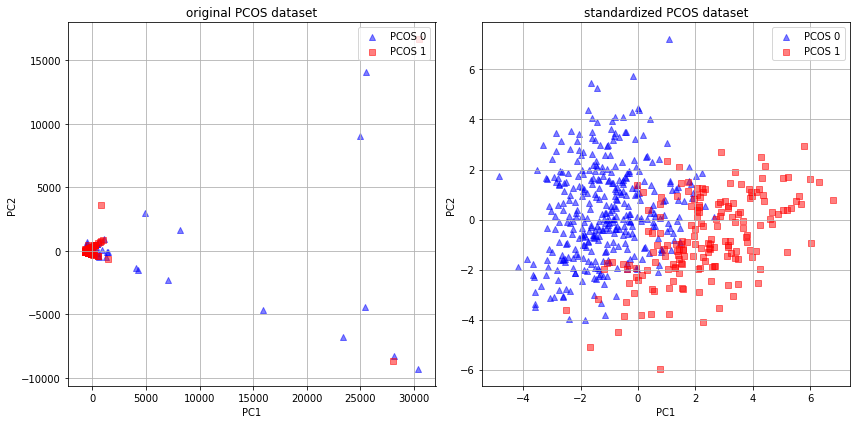

In [35]:
# comparison of scatter plots of standarized and original dataset after dimension reduction
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
for l, c, m in zip(range(0, 2), ('blue', 'red'), ('^', 's')):
    ax1.scatter(data_transformed[label == l, 0],
                data_transformed[label == l, 1],
                color=c,
                label='PCOS %s' % l,
                alpha=0.5,
                marker=m
                )
for l, c, m in zip(range(0, 2), ('blue', 'red'), ('^', 's')):
    ax2.scatter(data_scaled_transformed[label == l, 0],
                data_scaled_transformed[label == l, 1],
                color=c,
                label='PCOS %s' % l,
                alpha=0.5,
                marker=m
                )
ax1.set_title('original PCOS dataset')
ax2.set_title('standardized PCOS dataset')

for ax in (ax1, ax2):
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()
plt.show()


FOCUSED DATASET WITH SPECIFIC FEATURES TO ASSESS

In [36]:
data.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (years)',
       'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       'I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP Systolic (mmHg)',
       'BP Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

In [37]:
data_focused = data[['BMI','Cycle length(days)','FSH/LH','TSH (mIU/L)', 'AMH(ng/mL)','I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)','PCOS (Y/N)']]

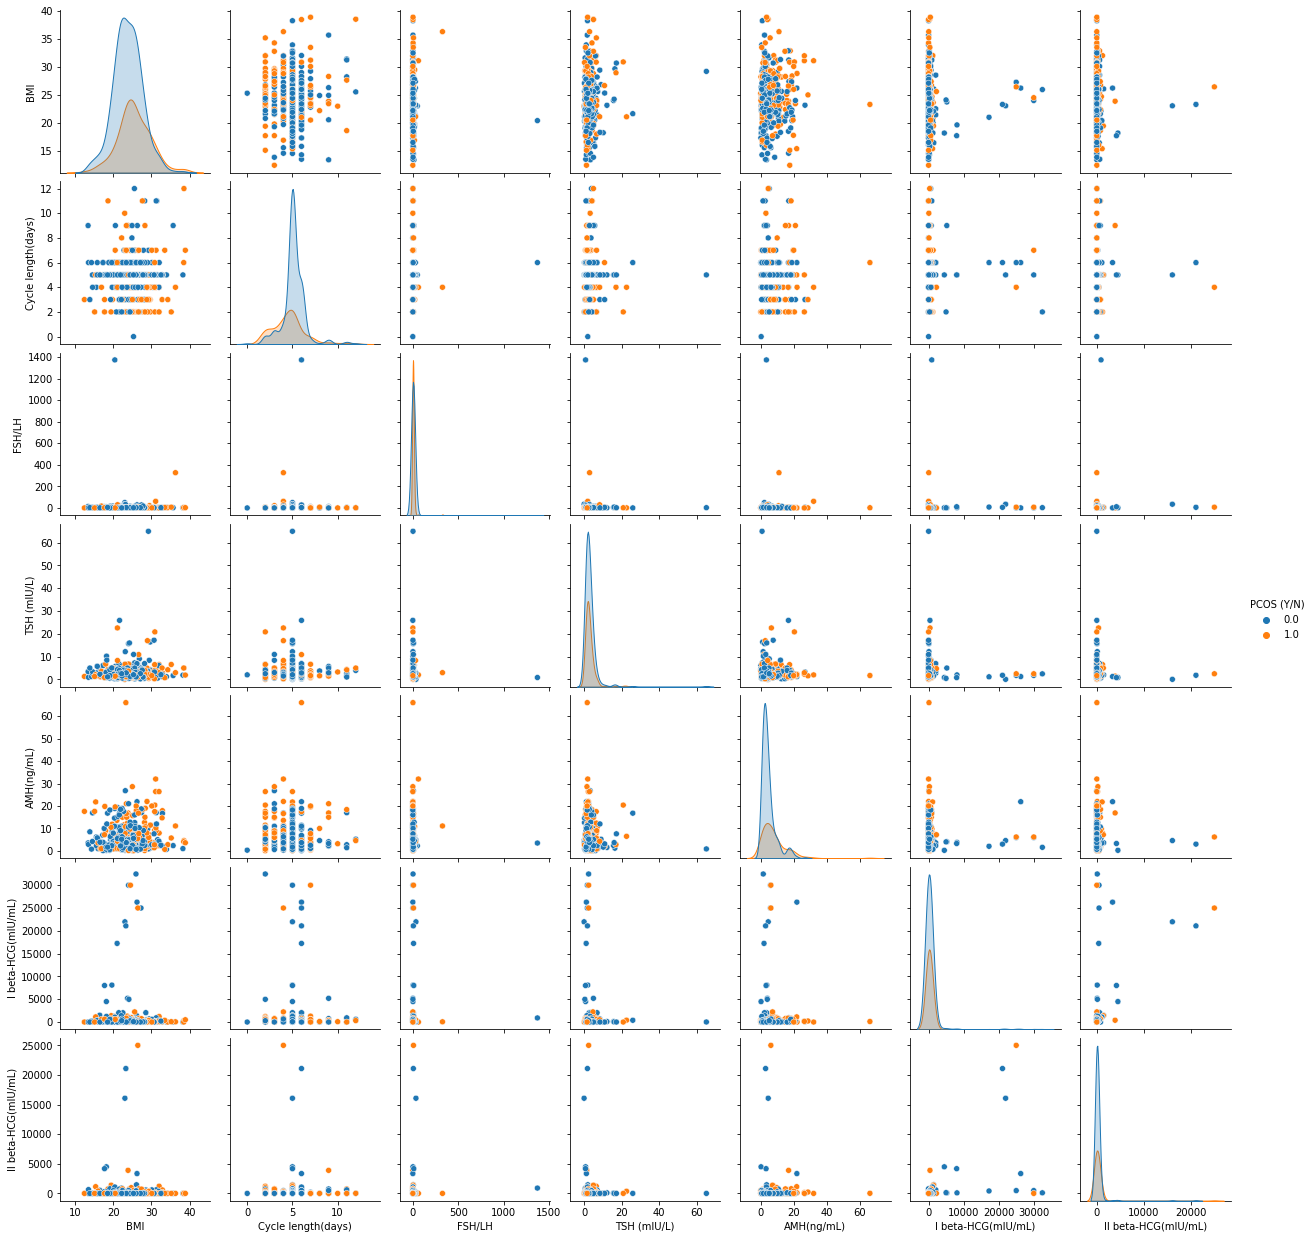

<Figure size 1322.62x1260 with 0 Axes>

In [38]:
sns_plot = sns.pairplot(data_focused, hue='PCOS (Y/N)',x_vars = ['BMI','Cycle length(days)','FSH/LH','TSH (mIU/L)', 'AMH(ng/mL)','I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)'],
y_vars = ['BMI','Cycle length(days)','FSH/LH','TSH (mIU/L)', 'AMH(ng/mL)','I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)'], diag_kind='kde')

sns_plot.savefig("pairplot6.png")

plt.clf() # Clean pairplot figure from sns 

Image(filename='pairplot6.png') # Show pairplot as image

EDA for Focused features

In [39]:
data.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (years)',
       'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       'I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP Systolic (mmHg)',
       'BP Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

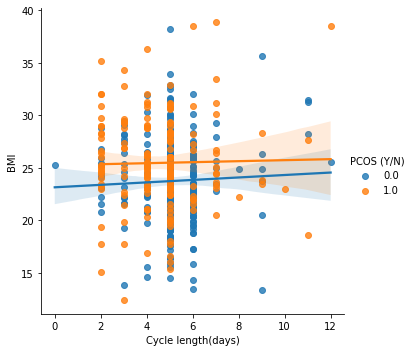

In [40]:
## Length of menstrual phase in PCOS vs normal with respect to BMI
fig=sns.lmplot(data=data,x='Cycle length(days)',y="BMI", hue="PCOS (Y/N)")
plt.show(fig)

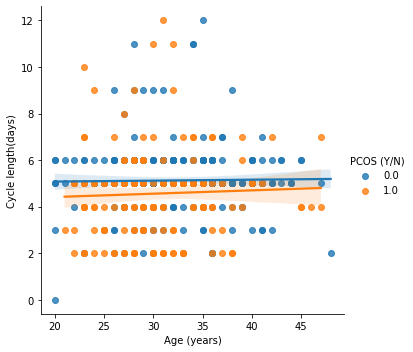

In [41]:
# Length of menstrual phase in PCOS vs normal with respect to Age
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (years)",y="Cycle length(days)", hue="PCOS (Y/N)")
plt.show(fig)

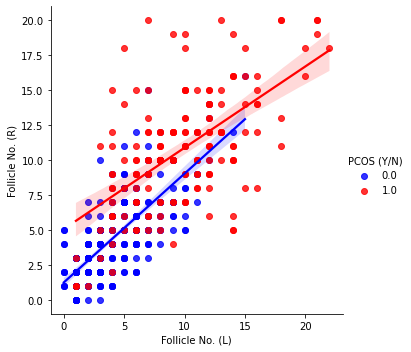

In [42]:
# Number of Follicles in Left and Right Ovaries 
color = ["blue", "red"]
fig=sns.lmplot(data=data,x='Follicle No. (L)',y= 'Follicle No. (R)', hue="PCOS (Y/N)",palette=color)
plt.show(fig)

HEATMAP

<AxesSubplot:>

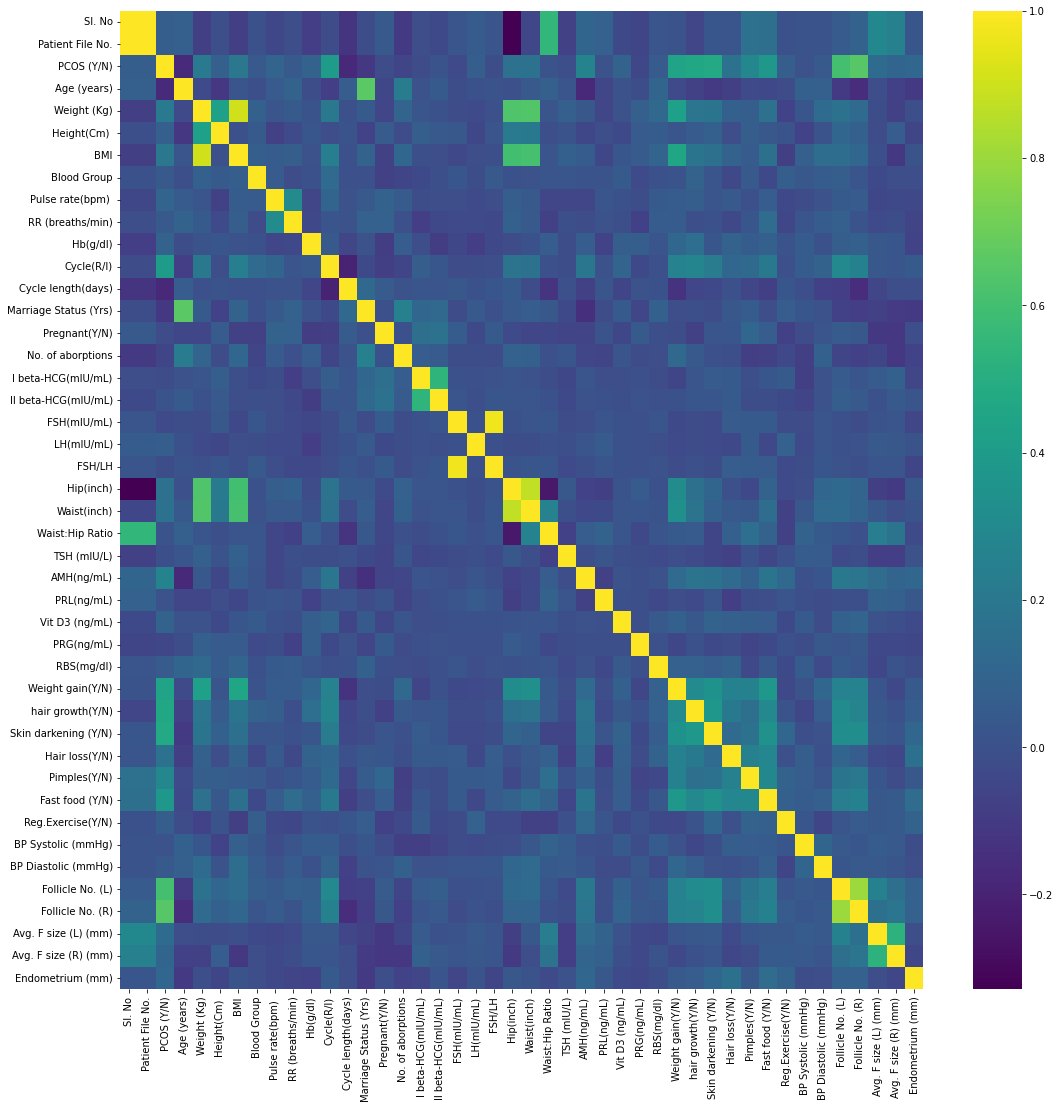

In [43]:
plt.subplots(figsize=(18,18))
sns.heatmap(data.corr(),cmap='viridis')

In [44]:
data.corr()['PCOS (Y/N)'].sort_values(ascending=False)

PCOS (Y/N)               1.000000
Follicle No. (R)         0.648327
Follicle No. (L)         0.603346
Skin darkening (Y/N)     0.475733
hair growth(Y/N)         0.464667
Weight gain(Y/N)         0.441047
Cycle(R/I)               0.401644
Fast food (Y/N)          0.376183
Pimples(Y/N)             0.286077
AMH(ng/mL)               0.264141
Weight (Kg)              0.211938
BMI                      0.199534
Hair loss(Y/N)           0.172879
Waist(inch)              0.164598
Hip(inch)                0.162297
Avg. F size (L) (mm)     0.132992
Endometrium (mm)         0.106648
Avg. F size (R) (mm)     0.097690
Pulse rate(bpm)          0.091821
Hb(g/dl)                 0.087170
Vit D3 (ng/mL)           0.085494
Height(Cm)               0.068254
Reg.Exercise(Y/N)        0.065337
LH(mIU/mL)               0.063879
Sl. No                   0.060998
Patient File No.         0.060998
RBS(mg/dl)               0.048922
BP Diastolic (mmHg)      0.038032
RR (breaths/min)         0.036928
Blood Group   

<AxesSubplot:>

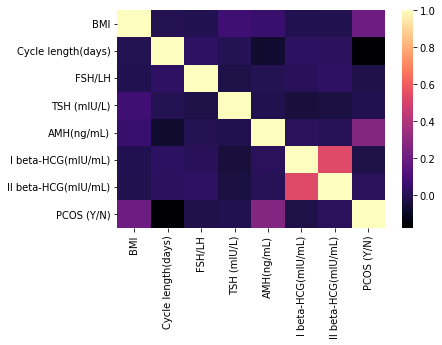

In [45]:
sns.heatmap(data_focused.corr(),cmap='magma')

In [46]:
#Identifying Features which have more than 0.40 correlation with PCOS(Y/N)

corr_features=data.corrwith(data["PCOS (Y/N)"]).abs().sort_values(ascending=False)
#features with correlation more than 0.3
corr_features=corr_features[corr_features>0.4].index
corr_features

Index(['PCOS (Y/N)', 'Follicle No. (R)', 'Follicle No. (L)',
       'Skin darkening (Y/N)', 'hair growth(Y/N)', 'Weight gain(Y/N)',
       'Cycle(R/I)'],
      dtype='object')

In [47]:
data_new = data[corr_features]
data_new.head()

,PCOS (Y/N),Follicle No. (R),Follicle No. (L),Skin darkening (Y/N),hair growth(Y/N),Weight gain(Y/N),Cycle(R/I)
0,0.0,3.0,3.0,0.0,0.0,0.0,2.0
1,0.0,5.0,3.0,0.0,0.0,0.0,2.0
2,1.0,15.0,13.0,0.0,0.0,0.0,2.0
3,0.0,2.0,2.0,0.0,0.0,0.0,2.0
4,0.0,4.0,3.0,0.0,0.0,0.0,2.0


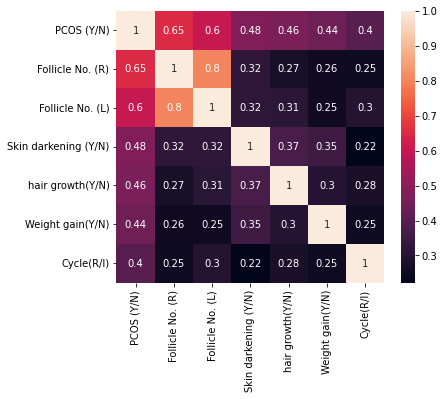

In [48]:
plt.figure(figsize=(6,5))
sns.heatmap(data_new.corr(), annot=True)
plt.show()

**PREDICTION MODEL BUILDING**

In [49]:
data.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', 'Age (years)',
       'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       'I beta-HCG(mIU/mL)', 'II beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP Systolic (mmHg)',
       'BP Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

In [50]:
X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into training and test sets with 65% train and 35% test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.35) 

In [51]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training Results: \n")

    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}\n")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}\n")
    print(f"CLASSIFICATION REPORT:\n{clf_report}\n")
    
    print("Testing Results: \n")
    
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}\n")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}\n")
    print(f"CLASSIFICATION REPORT:\n{clf_report}\n")

BAGGING CLASSIFIER

In [52]:
tree = DecisionTreeClassifier()
bag_clf_model = BaggingClassifier(base_estimator=tree, n_estimators=50, random_state=42)
bag_clf_model.fit(X_train, y_train)
evaluate(bag_clf_model, X_train, X_test, y_train, y_test)

Training Results: 

CONFUSION MATRIX:
[[244   0]
 [  0 107]]

ACCURACY SCORE:
1.0000

CLASSIFICATION REPORT:
             0.0    1.0  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    244.0  107.0       1.0      351.0         351.0

Testing Results: 

CONFUSION MATRIX:
[[109  11]
 [ 23  47]]

ACCURACY SCORE:
0.8211

CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.825758   0.810345  0.821053    0.818051      0.820079
recall       0.908333   0.671429  0.821053    0.789881      0.821053
f1-score     0.865079   0.734375  0.821053    0.799727      0.816925
support    120.000000  70.000000  0.821053  190.000000    190.000000



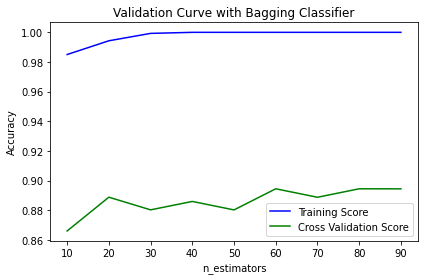

In [53]:
parameter_range = np.arange(10, 100, 10)
train_scores, valid_scores = validation_curve(bag_clf_model, X_train, y_train, param_name="n_estimators", param_range=parameter_range, cv=5)
mean_train_score = np.mean(train_scores, axis = 1)
std_train_score = np.std(train_scores, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(valid_scores, axis = 1)
std_test_score = np.std(valid_scores, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Bagging Classifier")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [54]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(bag_clf_model, X, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.90825688 0.85185185 0.82407407 0.92592593 0.77777778]
Average CV Score:  0.857577302072715
Number of CV Scores used in Average:  5


ADABOOST CLASSIFIER

In [55]:
ada_clf_model = AdaBoostClassifier(n_estimators=30)
ada_clf_model.fit(X_train, y_train)
evaluate(ada_clf_model, X_train, X_test, y_train, y_test)

Training Results: 

CONFUSION MATRIX:
[[241   3]
 [  4 103]]

ACCURACY SCORE:
0.9801

CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.983673    0.971698  0.980057    0.977686      0.980023
recall       0.987705    0.962617  0.980057    0.975161      0.980057
f1-score     0.985685    0.967136  0.980057    0.976411      0.980031
support    244.000000  107.000000  0.980057  351.000000    351.000000

Testing Results: 

CONFUSION MATRIX:
[[107  13]
 [ 21  49]]

ACCURACY SCORE:
0.8211

CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.835938   0.790323  0.821053    0.813130      0.819132
recall       0.891667   0.700000  0.821053    0.795833      0.821053
f1-score     0.862903   0.742424  0.821053    0.802664      0.818516
support    120.000000  70.000000  0.821053  190.000000    190.000000



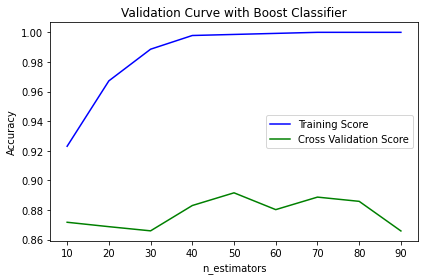

In [56]:
parameter_range = np.arange(10, 100, 10)
train_scores, valid_scores = validation_curve(ada_clf_model, X_train, y_train, param_name="n_estimators", param_range=parameter_range, cv=5)
mean_train_score = np.mean(train_scores, axis = 1)
std_train_score = np.std(train_scores, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(valid_scores, axis = 1)
std_test_score = np.std(valid_scores, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Boost Classifier")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [57]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(ada_clf_model, X, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.88990826 0.88888889 0.75925926 0.90740741 0.78703704]
Average CV Score:  0.8465001698946653
Number of CV Scores used in Average:  5


RANDOM FOREST CLASSIFIER

In [58]:
rf_clf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf_model.fit(X_train, y_train)
evaluate(rf_clf_model, X_train, X_test, y_train, y_test)

Training Results: 

CONFUSION MATRIX:
[[244   0]
 [  0 107]]

ACCURACY SCORE:
1.0000

CLASSIFICATION REPORT:
             0.0    1.0  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    244.0  107.0       1.0      351.0         351.0

Testing Results: 

CONFUSION MATRIX:
[[114   6]
 [ 23  47]]

ACCURACY SCORE:
0.8474

CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.832117   0.886792  0.847368    0.859455      0.852260
recall       0.950000   0.671429  0.847368    0.810714      0.847368
f1-score     0.887160   0.764228  0.847368    0.825694      0.841869
support    120.000000  70.000000  0.847368  190.000000    190.000000



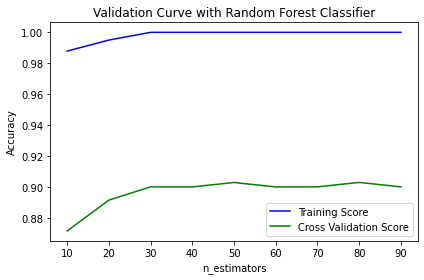

In [59]:
parameter_range = np.arange(10, 100, 10)
train_scores, valid_scores = validation_curve(rf_clf_model, X_train, y_train, param_name="n_estimators", param_range=parameter_range, cv=5)
mean_train_score = np.mean(train_scores, axis = 1)
std_train_score = np.std(train_scores, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(valid_scores, axis = 1)
std_test_score = np.std(valid_scores, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [60]:
k_folds = StratifiedKFold(n_splits = 10)

scores = cross_val_score(rf_clf_model, X, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.89090909 0.90740741 0.88888889 0.92592593 0.7962963  0.83333333
 0.92592593 0.90740741 0.7962963  0.87037037]
Average CV Score:  0.8742760942760942
Number of CV Scores used in Average:  10


PREDICTION USING PCA 

In [61]:
# Fit to data and predict using pipelined RandomForest and PCA
unscaled_clf = make_pipeline(PCA(n_components=2), RandomForestClassifier(random_state=42, n_estimators=1000))
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, RandomForest and PCA
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), RandomForestClassifier(random_state=42, n_estimators=1000))
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print("\nPrediction accuracy for the normal test dataset with PCA and Random Forest")
print(f"{accuracy_score(y_test, pred_test):.2%}\n")

print("\nPrediction accuracy for the standardized test dataset with PCA and Random Forest")
print(f"{accuracy_score(y_test, pred_test_std):.2%}\n")


Prediction accuracy for the normal test dataset with PCA and Random Forest
58.42%


Prediction accuracy for the standardized test dataset with PCA and Random Forest
82.11%



In [62]:
# Extract PCA from pipeline
pca = unscaled_clf.named_steps["pca"]
pca_std = std_clf.named_steps["pca"]

# Show first principal components
print(f"\nPC 1 without scaling:\n{pca.components_[0]}")
print(f"\nPC 1 with scaling:\n{pca_std.components_[0]}")


PC 1 without scaling:
[-4.80263854e-05  2.35968580e-05  1.61027228e-04 -3.62313113e-05
 -2.54108153e-05 -2.70785680e-05 -4.05478818e-05 -1.05153801e-05
  9.45534842e-06  4.26871344e-05  1.00144106e-04  1.81009411e-05
 -1.15791929e-05  9.62325051e-01  2.71894624e-01  4.84792789e-04
 -2.48054777e-04  3.68480066e-04  4.13559706e-05  1.94474580e-05
 -4.83005821e-07 -5.23872318e-05  7.89075656e-05 -9.20706713e-05
 -1.79906851e-03  3.46274206e-06 -1.97350138e-05 -1.49095897e-05
 -3.03791815e-06  3.05252809e-06  1.66559788e-06  1.22453018e-06
  3.62079852e-06  3.96697242e-06 -2.53227418e-04 -3.72555677e-05
  5.30465048e-05  3.43422267e-05  3.14639668e-05  5.06553677e-05
 -3.96976254e-05]

PC 1 with scaling:
[-0.07146859  0.35072931  0.09945577  0.33128697  0.01128596  0.07299813
  0.06119428  0.0546526   0.22724052 -0.05507688 -0.01965863  0.00037779
 -0.02109799  0.00215703  0.00056907 -0.01681821 -0.02713581 -0.01800075
  0.29166583  0.31601017  0.05054222 -0.03969981  0.10457281 -0.038184

PREDICTION USING ONLY HIGHLY CORRELATED FACTORS

In [63]:
y = data_new['PCOS (Y/N)']
X = data_new.drop(['PCOS (Y/N)'], axis=1)

In [64]:
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size=0.2)

In [65]:
model=LogisticRegression()
model.fit(X_train,y_train)
print(f"Score in Train Data : {model.score(X_train,y_train)}")


Score in Train Data : 0.9097222222222222


In [66]:
y_pred=model.predict(X_test)

In [67]:
print(f"Score in Test Data : {model.score(X_test,y_test)}")

cm=confusion_matrix(y_test, y_pred)
p_right=cm[0][0]+cm[1][1]
p_wrong=cm[0][1]+cm[1][0]

print(f"Right classification : {p_right}")
print(f"Wrong classification : {p_wrong}")
cm

Score in Test Data : 0.908256880733945
Right classification : 99
Wrong classification : 10


array([[72,  3],
       [ 7, 27]])

In [68]:
#Fitting the RandomForestClassifier to the training set

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.8990825688073395


In [69]:
tree = DecisionTreeClassifier()
bag_clf_model = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=42)
bag_clf_model.fit(X_train, y_train)
evaluate(bag_clf_model, X_train, X_test, y_train, y_test)

Training Results: 

CONFUSION MATRIX:
[[289   0]
 [  7 136]]

ACCURACY SCORE:
0.9838

CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.976351    1.000000  0.983796    0.988176      0.984179
recall       1.000000    0.951049  0.983796    0.975524      0.983796
f1-score     0.988034    0.974910  0.983796    0.981472      0.983690
support    289.000000  143.000000  0.983796  432.000000    432.000000

Testing Results: 

CONFUSION MATRIX:
[[72  3]
 [ 6 28]]

ACCURACY SCORE:
0.9174

CLASSIFICATION REPORT:
                 0.0        1.0  accuracy   macro avg  weighted avg
precision   0.923077   0.903226  0.917431    0.913151      0.916885
recall      0.960000   0.823529  0.917431    0.891765      0.917431
f1-score    0.941176   0.861538  0.917431    0.901357      0.916335
support    75.000000  34.000000  0.917431  109.000000    109.000000



In [70]:
ada_clf_model = AdaBoostClassifier(n_estimators=30)
ada_clf_model.fit(X_train, y_train)
evaluate(ada_clf_model, X_train, X_test, y_train, y_test)

Training Results: 

CONFUSION MATRIX:
[[271  18]
 [ 19 124]]

ACCURACY SCORE:
0.9144

CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.934483    0.873239  0.914352    0.903861      0.914210
recall       0.937716    0.867133  0.914352    0.902425      0.914352
f1-score     0.936097    0.870175  0.914352    0.903136      0.914276
support    289.000000  143.000000  0.914352  432.000000    432.000000

Testing Results: 

CONFUSION MATRIX:
[[71  4]
 [ 5 29]]

ACCURACY SCORE:
0.9174

CLASSIFICATION REPORT:
                 0.0        1.0  accuracy   macro avg  weighted avg
precision   0.934211   0.878788  0.917431    0.906499      0.916923
recall      0.946667   0.852941  0.917431    0.899804      0.917431
f1-score    0.940397   0.865672  0.917431    0.903034      0.917088
support    75.000000  34.000000  0.917431  109.000000    109.000000



In [71]:
rf_clf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf_model.fit(X_train, y_train)
evaluate(rf_clf_model, X_train, X_test, y_train, y_test)

Training Results: 

CONFUSION MATRIX:
[[288   1]
 [  6 137]]

ACCURACY SCORE:
0.9838

CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.979592    0.992754  0.983796    0.986173      0.983949
recall       0.996540    0.958042  0.983796    0.977291      0.983796
f1-score     0.987993    0.975089  0.983796    0.981541      0.983722
support    289.000000  143.000000  0.983796  432.000000    432.000000

Testing Results: 

CONFUSION MATRIX:
[[72  3]
 [ 7 27]]

ACCURACY SCORE:
0.9083

CLASSIFICATION REPORT:
                 0.0        1.0  accuracy   macro avg  weighted avg
precision   0.911392   0.900000  0.908257    0.905696      0.907839
recall      0.960000   0.794118  0.908257    0.877059      0.908257
f1-score    0.935065   0.843750  0.908257    0.889407      0.906581
support    75.000000  34.000000  0.908257  109.000000    109.000000

